# Quantum Graph Neural Networks (QGNNs)

- Verdon, G., McCourt, T., Luzhnica, E., Singh, V., Leichenauer, S., & Hidary, J. (2019). Quantum Graph Neural Networks. arXiv preprint arXiv:1909.12264. https://arxiv.org/abs/1909.12264
- Equivariant Quantum Graph Circuits: https://arxiv.org/abs/2112.05261
- Equivariant quantum circuits for learning on weighted graphs: https://www.nature.com/articles/s41534-023-00710-y
- All you need is spin: SU(2) equivariant variational quantum circuits based on spin networks: https://arxiv.org/abs/2309.07250
- Benchmarking variational quantum circuits with permutation symmetry: https://arxiv.org/pdf/2211.12711.pdf

A classical GNN maps a given graph structure into a lower dimensional vector space with characteristic features assigned to nodes and edges. This representation should preserve the topological graph structure, i.e. which nodes are connected, along with the deterministic features of the nodes and attributes of the edges. In the quantum graph structure, classical nodes can be mapped to quantum states, features to the characteristics of the states, edges to the interactions between states, and edge attributes to the strength of the interactions between the quantum states which form the graph. The larger structure of a classical model can then be embedded into the Hamiltonian operator you choose to act on the specified quantum states within the graph which will ultimately determine the dynamics and final state of the quantum algorithm.

## Import Packages and Device

In [72]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [73]:
!pip install particle
!pip install pennylane
!pip install torch_geometric

In [74]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
import copy
import random

# from numpy.random import default_rng
import pandas as pd
from tqdm import tqdm
from time import time
import os
import copy
from particle import Particle
# from sklearn.model_selection import train_test_split

import torch
from torch import nn as nn
# from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import Linear
import torch.nn.functional as F
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score


from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset, download_url
# from torch_geometric.nn import GCNConv
# from torch_geometric.nn import GATConv
# from torch_geometric.nn import Sequential
# from torch_geometric import nn
# from torch_geometric.nn import global_mean_pool


torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device: ',device)

np.random.seed(0)
torch.manual_seed(0)

Device:  cpu


## Load Data

In [75]:
path = './'
plot_path = './'

## Preprocess data

In [76]:
N=12500
x10_sorted_12500 = np.load('./x10_sorted_12500.npy')[:N]
y10_sorted_12500 = np.load('./y10_sorted_12500.npy')[:N]

In [77]:

def preprocess_fixed_nodes_quantum(x_data, y_data, nodes_per_graph=10):  # ,masses):
    print("--- Finding All Unique Particles ---")
    unique_particles = np.unique(x_data[:, :, 3])
    x_data = torch.tensor(x_data)
    y_data = torch.tensor(y_data)
    print()
    print("--- Inserting Masses ---")
    masses = torch.zeros((x_data.shape[0], x_data.shape[1]))
    for i, particle in tqdm(enumerate(unique_particles)):
        if particle != 0:
            mass = Particle.from_pdgid(particle).mass / 1000
            inds = torch.where(particle == x_data[:, :, 3])
            masses[inds] = mass  # GeV
    print()
    print("--- Calculating Momenta and Energies ---")
    # theta = torch.arctan(torch.exp(-X[:,:,1]))*2 # polar angle
    pt = x_data[:, :, 0]  # transverse momentum
    rapidity = x_data[:, :, 1]  # rapidity
    phi = x_data[:, :, 2]  # azimuthal angle

    mt = (pt**2 + masses**2).sqrt()  # Transverse mass
    energy = mt * torch.cosh(rapidity)  # Energy per multiplicity bin
    e_per_jet = energy.sum(
        axis=1
    )  # total energy per jet summed across multiplicity bins

    px = pt * torch.cos(phi)  # momentum in x
    py = pt * torch.sin(phi)  # momentum in y
    pz = mt * torch.sinh(rapidity)  # momentum in z

    # three momentum
    p = torch.cat((px[:, :, None], py[:, :, None], pz[:, :, None]), dim=2)

    p_per_jet = (p).sum(axis=1)  # total componet momentum per jet
    pt_per_Mbin = (
        (p_per_jet[:, :2] ** 2).sum(axis=1).sqrt()
    )  # transverse momentum per jet
    mass_per_jet = (e_per_jet**2 - (p_per_jet**2).sum(axis=1)).sqrt()  # mass per jet
    rapidity_per_jet = (
        torch.log((e_per_jet + p_per_jet[:, 2]) / (e_per_jet - p_per_jet[:, 2])) / 2
    )  # rapidity per jet from analytical formula
    end_multiplicity_indx_per_jet = (
        (pt != 0).sum(axis=1).int()
    )  # see where the jet (graph) ends

    x_data = torch.cat(
        (x_data[:, :, :3], x_data[:, :, 4:], masses[:, :, None], energy[:, :, None], p),
        dim=2,
    )

    x_data_max = (x_data.max(dim=1).values).max(dim=0).values
    x_data = x_data / x_data_max

    print()
    print("--- Calculating Edge Tensors ---")
    N = x_data[:, 0, 3].shape[0]  # number of jets (graphs)
    M = nodes_per_graph  # x_data[0,:,3].shape[0]  # number of max multiplicty
    connections = nodes_per_graph
    edge_tensor = torch.zeros((N, M, M))
    edge_indx_tensor = torch.zeros(
        (N, 2, connections * (connections - 1))
    )  # M*(connections-1) is the max number of edges we allow per jet
    edge_attr_matrix = torch.zeros((N, connections * (connections - 1), 1))
    #     fixed_edges_list = torch.tensor([ [i,j] for i in range(connections) for j in range(connections) if i!=j]).reshape(2,90)

    for jet in tqdm(range(N)):
        stop_indx = end_multiplicity_indx_per_jet[
            jet
        ]  # connections # stop finding edges once we hit zeros -> when we hit 10
        if end_multiplicity_indx_per_jet[jet] >= connections:
            for m in range(connections):
                #                 inds_edge = np.argsort((energy[jet,m]+energy[jet,:stop_indx])**2-torch.sum((p[jet,m,:stop_indx]+p[jet,:stop_indx,:])**2,axis=1))[:connections]
                #                 edge_tensor[jet,m,:] = (energy[jet,m]+energy[jet,:connections])**2-torch.sum((p[jet,m,:]+p[jet,:connections,:])**2,axis=1)
                #                 edge_tensor[jet,m,m] = 0.
                #                 edge_tensor[jet,m,m]=((energy[jet,m]+energy[jet,m])**2-torch.sum((p[jet,m,:]+p[jet,m,:])**2,axis=0))
                # inds_edge = torch.sqrt( (phi[jet,m]-phi[jet,:])**2 + (rapidity[jet,m]-rapidity[jet,:])**2 ).argsort()[:connections]
                # edge_tensor[jet,m,:] = torch.sqrt( (phi[jet,m]-phi[jet,inds_edge])**2 + (rapidity[jet,m]-rapidity[jet,inds_edge])**2 )
                edge_tensor[jet, m, :] = torch.sqrt(
                    (phi[jet, m] - phi[jet, :connections]) ** 2
                    + (rapidity[jet, m] - rapidity[jet, :connections]) ** 2
                )
            #                 inds_edge = np.argsort( (energy[jet,m]+energy[jet,:stop_indx])**2-torch.sum((p[jet,m,:stop_indx]+p[jet,:stop_indx,:])**2,axis=1) )[:connections]
            #                 edge_tensor[jet,m,inds_edge] = (energy[jet,m]+energy[jet,inds_edge])**2-torch.sum((p[jet,m,:]+p[jet,inds_edge,:])**2,axis=1)
            edges_exist_at = torch.where(edge_tensor[jet, :, :].abs() > 0)

            #             edge_indx_tensor[jet,:,:(edge_tensor[jet,:,:].abs()>0).sum()] = fixed_edges_list
            edge_indx_tensor[jet, :, : (edge_tensor[jet, :, :].abs() > 0).sum()] = (
                torch.cat(
                    (edges_exist_at[0][None, :], edges_exist_at[1][None, :]), dim=0
                ).reshape((2, edges_exist_at[0].shape[0]))
            )
            edge_attr_matrix[jet, : (edge_tensor[jet, :, :].abs() > 0).sum(), 0] = (
                edge_tensor[jet, edges_exist_at[0], edges_exist_at[1]].flatten()
            )

    end_edges_indx_per_jet = (edge_attr_matrix != 0).sum(axis=1).int()
    keep_inds = torch.where(end_edges_indx_per_jet >= connections)[0]

    edge_tensor = edge_tensor / edge_tensor.max()
    edge_attr_matrix = edge_attr_matrix / edge_attr_matrix.max()

    graph_help = torch.cat(
        (
            (energy.max(axis=1).values / e_per_jet).reshape(
                x_data[:, 0, 3].shape[0], 1
            ),
            (mass_per_jet).reshape(x_data[:, 0, 3].shape[0], 1),
            (end_multiplicity_indx_per_jet).reshape(x_data[:, 0, 3].shape[0], 1).int(),
            (end_edges_indx_per_jet).reshape(x_data[:, 0, 3].shape[0], 1).int(),
        ),
        dim=1,
    )

    print()
    print("--- Calculating Quantum Hamiltonians ---")
    quantum_hamiltonians = torch.zeros(
        (N, 2, int(2**M), int(2**M))
    )  # 0: coupling, 1: transverse
    for idx in tqdm(keep_inds):
        quantum_hamiltonians[idx, 0, :, :] = create_hamiltonian_matrix_interaction(
            nodes_per_graph, edge_indx_tensor[idx], edge_attr_matrix[idx]
        )
        quantum_hamiltonians[idx, 1, :, :] = create_hamiltonian_matrix_transverse(
            nodes_per_graph
        )

    return (
        x_data[keep_inds, :nodes_per_graph],
        y_data[keep_inds].long(),
        edge_tensor[keep_inds],
        edge_indx_tensor[keep_inds].long(),
        edge_attr_matrix[keep_inds],
        graph_help[keep_inds],
        quantum_hamiltonians,
    )


def create_hamiltonian_matrix_interaction(
    nodes_per_graph,
    edge_indx_tensor,
    edge_attr_matrix,
    term_dictionary={
        0: [np.identity(2), np.identity(2)],
        1: [qml.matrix(qml.PauliZ)(0), qml.matrix(qml.PauliZ)(0)],
    },
):
    # n_qubits == number of nodes in graph
    # graph == Data frame
    # weights == edge_attr
    n_qubits = nodes_per_graph  # graph.x.shape[0]
    full_matrix = np.zeros((2**n_qubits, 2**n_qubits))
    # Creates the interaction component of the Hamiltonian
    weights = edge_attr_matrix  # graph.edge_attr
    fraction = 1.0 / 4.0
    number_of_terms = len(term_dictionary)
    for term in range(number_of_terms):
        for i, edge in enumerate(edge_indx_tensor.T):  # graph.edge_index.T):
            interaction_term = 1
            for qubit in range(n_qubits):
                if qubit in edge:
                    if qubit == edge[0]:
                        interaction_term = np.kron(
                            interaction_term, term_dictionary[term][0]
                        )
                    elif qubit == edge[1]:
                        interaction_term = np.kron(
                            interaction_term, term_dictionary[term][1]
                        )
                else:
                    interaction_term = np.kron(interaction_term, np.identity(2))

        if np.all(term_dictionary[term][0] == qml.matrix(qml.PauliZ)(0)):
            full_matrix += -fraction * weights[i].numpy() * interaction_term
        else:
            full_matrix += fraction * weights[i].numpy() * interaction_term
    return torch.tensor(full_matrix)


def create_hamiltonian_matrix_transverse(nodes_per_graph):
    n_qubits = nodes_per_graph  # graph.x.shape[0]
    full_matrix = np.zeros((2**n_qubits, 2**n_qubits))
    # Creates the bias components of the matrix
    for i in range(n_qubits):
        x_term = 1
        for j in range(n_qubits):
            if j == i:
                x_term = np.kron(x_term, qml.matrix(qml.PauliX)(0))
            else:
                x_term = np.kron(x_term, np.identity(2))
        full_matrix += x_term
    return torch.tensor(full_matrix)


In [78]:
nodes_per_graph = 3
x_data_proc, y_data_proc, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help, quantum_hamiltonians = preprocess_fixed_nodes_quantum(x10_sorted_12500,y10_sorted_12500,nodes_per_graph = nodes_per_graph) #,masses[:N])
N = x_data_proc.shape[0]

--- Finding All Unique Particles ---

--- Inserting Masses ---


14it [00:00, 596.34it/s]



--- Calculating Momenta and Energies ---

--- Calculating Edge Tensors ---


100%|██████████| 12500/12500 [00:10<00:00, 1202.51it/s]



--- Calculating Quantum Hamiltonians ---


100%|██████████| 12500/12500 [02:22<00:00, 87.71it/s] 


In [79]:
print('----- Check for the correctly sized tensors -----')
print()
print(f'Jet Data: {x_data_proc.shape}')
print(f'Classification: {y_data_proc.shape}')
print(f'Full Edge Information: {edge_tensor.shape}')
print(f'Edge Index Information: {edge_indx_tensor.shape}')
print(f'Edge Attribute Information: {edge_attr_matrix.shape}')
print(f'Graph Structure Information: {graph_help.shape}')
print(f'Quantum Information: {quantum_hamiltonians.shape}')
print('\n')
print('----- Check that each tensor is normalized -----')
print()
print(f'Jet Data max: {torch.max(x_data_proc)}')
print(f'Classification Max: {torch.max(y_data_proc)}')
print(f'Edge Length Max: {torch.max(edge_tensor)}')

----- Check for the correctly sized tensors -----

Jet Data: torch.Size([12500, 3, 8])
Classification: torch.Size([12500])
Full Edge Information: torch.Size([12500, 3, 3])
Edge Index Information: torch.Size([12500, 2, 6])
Edge Attribute Information: torch.Size([12500, 6, 1])
Graph Structure Information: torch.Size([12500, 4])
Quantum Information: torch.Size([12500, 2, 8, 8])


----- Check that each tensor is normalized -----

Jet Data max: 1.0
Classification Max: 1
Edge Length Max: 1.0


In [80]:
print('----- Check the structure of the dataset -----')
print()
print(f'Number of graphs (jets): {x_data_proc.shape[0]}')
print(r'Number of features per node (p_T(M),y,phi,m,E,px,py,pz): '+f'{x_data_proc.shape[2]}')
print(f'Number of classes (2: Quarks or Gluons): {np.unique(y_data_proc).shape[0]}')
print()
print('----- Check the structure of one graph -----')
print()
i=0
number_of_edges = graph_help[i,3]
# Gather some statistics about the first graph.
print(f'Number of nodes (particle IDs): {x_data_proc[i,:,0].shape[0]}')
print(f'Number of edges: {number_of_edges}')
print(f'Average node degree: {number_of_edges / x_data_proc[i,:,0].shape[0]:.2f}')
print(f'Is undirected: {True}')

----- Check the structure of the dataset -----

Number of graphs (jets): 12500
Number of features per node (p_T(M),y,phi,m,E,px,py,pz): 8
Number of classes (2: Quarks or Gluons): 2

----- Check the structure of one graph -----

Number of nodes (particle IDs): 3
Number of edges: 6.0
Average node degree: 2.00
Is undirected: True


In [81]:
# Create a dataset class
class Create_Dataset(Dataset):
    def __init__(self, edge_index, x, edge_attr, y, graph_info, hamiltonians, transform=None):
        self.edge_index = edge_index
        self.x          = x
        self.edge_attr  = edge_attr
        self.y          = y
        self.graph_info = graph_info
        self.hamiltonians = hamiltonians
        self.transform  = transform

    def __len__(self):
        return self.y.shape[0]

    # Could also just define an x,y,z then pass these variables
    # in the training functions over the loop for batch (actually think that way is easier to read)
    def __getitem__(self, index):
        sample = {'edge_index': self.edge_index[index,:,:], #self.graph_info[index,3]],
                'x': self.x[index,:,:], #int(self.graph_info[index,2]),:],
                'edge_attr': self.edge_attr[index,:], #self.graph_info[index,3]],
                'hams': self.hamiltonians[index,:,:,:],
                'y': self.y[index]  }

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

In [82]:
train_index   = int(N*0.8)
val_index    = int(N*0.9)
batch_size = 1

# Create Datasets for Torch for the training and testing pahses
dataset = []
for i in tqdm(range(N)):
    dataset.append(Data(edge_index=edge_indx_tensor[i,:,:int(graph_help[i,3])],
                        x=x_data_proc[i,:int(graph_help[i,2]),:],
                        edge_attr=edge_attr_matrix[i,:int(graph_help[i,3])],
                        y=y_data_proc[i],
                        pos = quantum_hamiltonians[i,:]))

training_data = dataset[:train_index]
val_data      = dataset[train_index:val_index]
test_data     = dataset[val_index:]
# Create data loaders
train_quantum_dataloader = DataLoader(training_data,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0)

val_quantum_dataloader  = DataLoader(val_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

test_quantum_dataloader  = DataLoader(test_data,
                              batch_size = batch_size,
                              shuffle = False,
                              num_workers = 0)

print(f'Number of training graphs: {train_index}')
print(f'Number of validation graphs: {val_index-train_index}')
print(f'Number of test graphs: {N-val_index}')

100%|██████████| 12500/12500 [00:02<00:00, 6019.85it/s]

Number of training graphs: 10000
Number of validation graphs: 1250
Number of test graphs: 1250


In [83]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Quantum Graph Neural Network (QGNN)

In [84]:
def get_distance(tuple1,tuple2):
    return np.sqrt((tuple1[0]-tuple2[0])**2+(tuple1[1]-tuple2[1])**2)

Plot of chosen jets for clustering

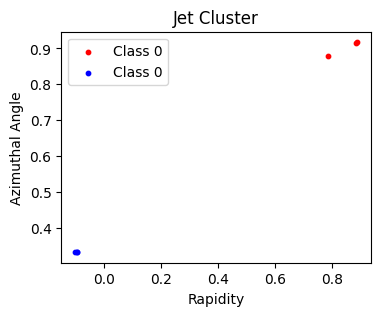

In [85]:
i=0
j=1
M = nodes_per_graph
fig = plt.figure(figsize=(4,3))
plt.scatter(x_data_proc[i,:,1],x_data_proc[i,:,2],c='r',s=10,label='Class '+str(y_data_proc[i].item()) ) #%(2*np.pi)
plt.scatter(x_data_proc[j,:,1],x_data_proc[j,:,2],c='b',s=10,label='Class '+str(y_data_proc[j].item()) ) #%(2*np.pi)
plt.title('Jet Cluster')
plt.xlabel('Rapidity')
plt.ylabel('Azimuthal Angle')
plt.legend()

In [86]:
i = 0
pos = {j: (x_data_proc[i,j,1]%(2*np.pi), x_data_proc[i,j,2]%(2*np.pi)) for j in range(M)}
make_jet_edges = [ (i,j) for i in pos for j in pos if i<j ]

In [87]:
# number of qubits
qubit_number = nodes_per_graph # M*2
qubits = range(qubit_number)

In [88]:
print(qubit_number)

3


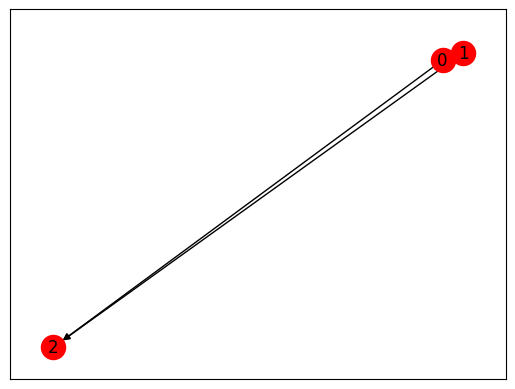

In [89]:
ising_graph = nx.DiGraph()
ising_graph.add_nodes_from(pos)
ising_graph.add_edges_from(make_jet_edges)
nx.draw_networkx(ising_graph, pos, node_color='red', edgelist=make_jet_edges)

In [90]:
term_dictionary = {0: [np.identity(2),np.identity(2)], 1: [qml.matrix(qml.PauliZ)(0), qml.matrix(qml.PauliZ)(0)]}

In [91]:
graph = dataset[0]

In [92]:
graph.edge_index.shape

torch.Size([2, 6])

In [93]:
graph.edge_index.shape

torch.Size([2, 6])

In [94]:
def create_hamiltonian_matrix_interaction(graph,
                              term_dictionary =  {0: [np.identity(2),np.identity(2)], 1: [qml.matrix(qml.PauliZ)(0), qml.matrix(qml.PauliZ)(0)]}):
    # n_qubits == number of nodes in graph
    # graph == Data frame
    # weights == edge_attr
    n_qubits = graph.x.shape[0]
    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))
    # Creates the interaction component of the Hamiltonian
    weights = graph.edge_attr
    fraction = 1./4.
    number_of_terms = len(term_dictionary)
    for term in range(number_of_terms):
        for i, edge in enumerate(graph.edge_index.T):
            interaction_term = 1
            for qubit in range(n_qubits):
                if qubit in edge:
                    if qubit==edge[0]:
                        interaction_term = np.kron(interaction_term, term_dictionary[term][0] )
                    elif qubit==edge[1]:
                        interaction_term = np.kron(interaction_term, term_dictionary[term][1] )
                else:
                    interaction_term = np.kron(interaction_term, np.identity(2) )

        if np.all(term_dictionary[term][0]==qml.matrix(qml.PauliZ)(0)):
            full_matrix += -fraction*weights[i].numpy()*interaction_term
        else:
            full_matrix +=  fraction*weights[i].numpy()*interaction_term
    return full_matrix

def create_hamiltonian_matrix_transverse(graph):
    n_qubits = graph.x.shape[0]
    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))
    # Creates the bias components of the matrix
    for i in range(n_qubits):
        x_term = 1
        for j in range(n_qubits):
            if j==i:
                x_term = np.kron(x_term, qml.matrix(qml.PauliX)(0))
            else:
                x_term = np.kron(x_term, np.identity(2) )
        full_matrix += x_term
    return full_matrix

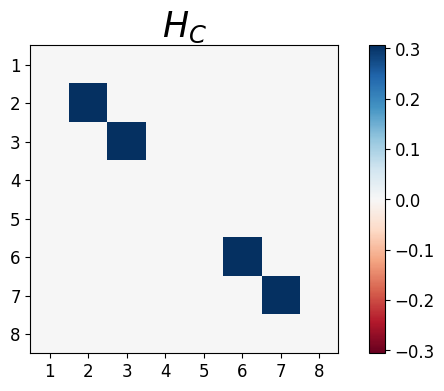

In [95]:
# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix_interaction(graph = graph)
plt.figure(figsize=(8,4))
plt.imshow(ham_matrix, cmap="RdBu",vmin=-np.max(ham_matrix),vmax=np.max(ham_matrix))
plt.title('$H_C$',fontsize=25)
plt.xticks(ticks = [i for i in range(2**qubit_number)], labels =  [i+1 for i in range(2**qubit_number)], fontsize=12)
plt.yticks(ticks = [i for i in range(2**qubit_number)], labels =  [i+1 for i in range(2**qubit_number)], fontsize =12)
cbar = plt.colorbar()
# cbar.set_label(label='',size=25)
cbar.ax.tick_params(labelsize=12)
plt.savefig(plot_path+'hc.png',bbox_inches='tight')

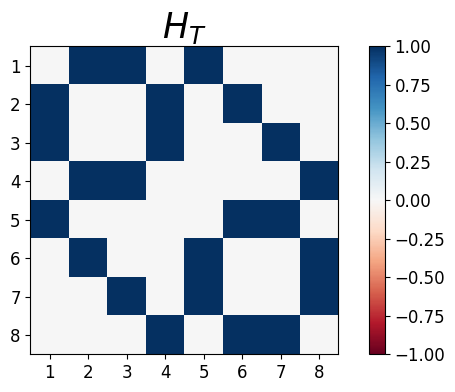

In [96]:
# Prints a visual representation of the Hamiltonian matrix
ham_matrix = create_hamiltonian_matrix_transverse(graph = graph)
plt.figure(figsize=(8,4))
plt.imshow(ham_matrix, cmap="RdBu",vmin=-np.max(ham_matrix),vmax=np.max(ham_matrix))
plt.title('$H_T$',fontsize=25)
plt.xticks(ticks = [i for i in range(2**qubit_number)], labels =  [i+1 for i in range(2**qubit_number)], fontsize=12)
plt.yticks(ticks = [i for i in range(2**qubit_number)], labels =  [i+1 for i in range(2**qubit_number)], fontsize =12)
cbar = plt.colorbar()
# cbar.set_label(label='',size=25)
cbar.ax.tick_params(labelsize=12)
plt.savefig(plot_path+'ht.png',bbox_inches='tight')

# Quantum Graph Neural Network (QGNN)

In [97]:
reg1 = copy.copy([i for i in range(nodes_per_graph) ])  # load original graph

In [98]:
qubit_number

3

## QGNN Layers

In [99]:
def state_evolve(hamiltonian, qubits, eta, q):
    U = torch.linalg.matrix_exp(-1j * eta * hamiltonian).cfloat()
    U = q@U@q.T.conj()
    qml.QubitUnitary(U, wires=qubits)

def qgcnn(inputs,weights):
    # ham_matrix1, ham_matrix2, tham_matrix1, tham_matrix2 = form_hamiltonians(graph1 = graphs[0], graph2 = graphs[1])
    # Prepares the low energy state in the two registers
    embedding_features = int(2**qubit_number)
    low_energy_state = inputs[1,:embedding_features]
    constant = torch.tensor([1.]).cfloat().to(device)
    qml.QubitStateVector(torch.kron(low_energy_state,constant), wires=reg1)
    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    inputs = inputs[0,:].reshape(batch_size,2,embedding_features,embedding_features)
    if batch_size==1:
        inputs = inputs.reshape(2,embedding_features,embedding_features)
        coeffs = weights[:,:int(n_layers*2)].reshape(n_layers,2)
        As = weights[:,int(n_layers*2):].reshape(n_layers,2,embedding_features,embedding_features)

    for j in range(coeffs.shape[0]):
      A = As[j,0,:,:].cfloat() + 1j*As[j,1,:,:].cfloat()
      I = torch.eye(A.shape[0],dtype = torch.cfloat).to(device)
      A = A + A.T.conj()
      q = (A - 1j*I)@torch.linalg.inv(A + 1j*I)
      if batch_size==1:
          state_evolve(inputs[0,:,:],  reg1, coeffs[j,0], q )
          state_evolve(inputs[1,:,:],  reg1, coeffs[j,1], q )
      else:
          state_evolve(inputs[:,0,:,:],  reg1, coeffs[j,0], q )
          state_evolve(inputs[:,1,:,:],  reg1, coeffs[j,1], q )
    return [qml.state()]

# Define a custom complex activation function (nn.Module)
class complex_activation(nn.Module):
    def forward(self, x):
        return nn.ReLU()(x.real) + 1.j * nn.ReLU()(x.imag)

qgcnn_dev = qml.device('default.qubit', wires=qubit_number)#, shots=shots)
# Defines the new QNode
qgcnn_qnode = qml.QNode(qgcnn,
                        device=qgcnn_dev,
                        interface = 'torch', #,#interface='torch', #interface = 'autograd'
                        diff_method='backprop')

class eigs_fn_torch(nn.Module):
    def forward(self, inputs, qstates_comp_basis):
        # Compute rotation matrices and eigenvalues
        qstates_comp_basis = qstates_comp_basis.flatten().cfloat()
        qstates_density_matrix =  qstates_comp_basis@qstates_comp_basis.T
        q,r = torch.linalg.qr(qstates_density_matrix)
        coupling_ham = (inputs[0].reshape(2,int(2**nodes_per_graph),int(2**nodes_per_graph)) )[0,:,:].cfloat()
        rotUC1 = q @ torch.linalg.matrix_exp( -1j * coupling_ham )
        UC1eigs = torch.linalg.eigvals(rotUC1)
        return qstates_comp_basis.reshape(1,qstates_comp_basis.shape[0]) #UC1eigs.reshape(1,UC1eigs.shape[0])

class product_state(nn.Module):
    def forward(self, qstates_comp_basis):
        qstates_comp_basis = qstates_comp_basis.flatten().cfloat()
        return qstates_comp_basis.reshape(1,qstates_comp_basis.shape[0])

class construct_low_energy_state(nn.Module):
    def forward(self, encoded_state):
        term = torch.tensor([1.]).cfloat().to(device)
        for i in range(encoded_state.shape[0]):
            term = torch.kron(encoded_state[i,:],term)
        normalize_factor = torch.sqrt(torch.abs(torch.conj(term)@term))
        term = term/normalize_factor
        return term

## QGNN Model

In [100]:
class quantum_iso_model(torch.nn.Module):
    def __init__(self, weight_shapes):
        super().__init__()
        # self.weights = torch.nn.Parameter(torch.randn(n_layers, gamma_and_eta))
        # self.transform = torch.nn.Identity()
        self.encoder = nn.Sequential( nn.Linear(x_data_proc.shape[2], 16, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(16, 16, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(16, 2, dtype=torch.cfloat) )

        self.qlayer = qml.qnn.TorchLayer(qgcnn_qnode, weight_shapes)
        self.eigs   = eigs_fn_torch()
        self.product_state = product_state()
        self.state  = construct_low_energy_state()

        self.decoder = nn.Sequential( nn.Linear(2**qubit_number, 5*2**qubit_number, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(5*2**qubit_number, 4*2**qubit_number, dtype=torch.cfloat),
                                      complex_activation(),
                                      nn.Linear(4*2**qubit_number, 2, dtype=torch.cfloat) )

    def forward(self, inputs, features):
        embedding = self.encoder(features)
        initial_state = self.state(embedding)
        initial_state = nn.functional.pad(initial_state, (0,inputs.shape[1]-initial_state.shape[0]), mode='constant', value=0)
        x = self.qlayer(torch.vstack([inputs,initial_state]))
        x = self.product_state(x)
        h = self.decoder(x)
        return (h*h.conj()).real

## QGNN Training Function

In [101]:
def quantum_training(train_dataloader,
                     val_dataloader,
                     epochs,
                     loss_fn,
                     model,
                     optimizer):

    size = len(train_dataloader)
    history = { 'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}

    best_train_loss = torch.inf
    best_val_loss = torch.inf
    best_model = None
    best_train_acc = 0.
    best_val_acc = 0.
    best_auc = 0.
    best_epoch = 0
    count = 0
    current_val_loss = 0
    size_val = len(val_dataloader)
    first_idx = torch.arange(0,size_val)
    start = time()
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, _ , _ = train(model, optimizer, epoch, train_dataloader, backprop=True)
        val_loss, val_acc, val_label, val_pred = train(model, optimizer, epoch, val_dataloader, backprop=False)

        y_score = val_pred[(first_idx,val_label.astype('int32'))]
        auc_score = roc_auc_score(val_label, y_score)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print('\n')

        if val_loss <= best_val_loss:
          best_train_loss = train_loss
          best_val_loss = val_loss
          best_train_acc = train_acc
          best_val_acc = val_acc

        if best_auc <= auc_score and epoch>=15:
          # best_model = copy.deepcopy(model)
          # best_model_wts = copy.deepcopy(model.state_dict())
          best_auc = auc_score
          print(f'Rerun and stop at epoch {epoch} to attain the best classifier.')

          # best_model = copy.deepcopy(model)
          # best_model_wts = copy.deepcopy(model.state_dict())
          # if current_val_loss>best_val_loss:
          #   count=0
          # if count==0:
          #   best_auc = auc_score
          #   current_val_loss = best_val_loss
          #   count+=1

        if epoch % 1 == 0 or epoch==epochs-1: #args.test_interval == 0:
          print("Epoch: %d |  Best Train Loss: %.8f | Best Val Loss: %.8f | Best Train Acc: %.8f | Best Val Acc: %.8f" % (epoch, best_train_loss, best_val_loss, best_train_acc, best_val_acc))
          print('Epoch: %d |  VAL AUC: %.8f \n' % (epoch, auc_score))

    end = time()
    print(f'Training Complete. Total Time (s): {end-start}')
    return {'model': best_model, 'history': history}


def train(model, optimizer, epoch, loader, backprop=True):
    size = len(loader)
    num_correct = 0
    running_loss = 0.
    loss_list = []
    if backprop:
        model.train()
    else:
        model.eval()
    all_labels = np.zeros((size,))
    all_labels_pred = np.zeros((size,2))
    for batch_idx, data in enumerate(loader):
        if batch_idx==0:
            node_size, n_feat = data[0].x.size()
        batch_size = data.x.shape[0]//node_size
        inputs = data.pos.reshape(batch_size,2*int(2**node_size)*int(2**node_size)).to(device)
        initial_node_features = data.x.cfloat().to(device)
        labels = data.y.long().reshape(batch_size,).to(device)

        labels_pred = model(inputs,initial_node_features)
        loss = loss_fn(labels_pred,labels)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        if backprop:
            loss.backward()
            optimizer.step()
        else:
          all_labels[batch_idx] = labels
          all_labels_pred[batch_idx] = labels_pred.detach().cpu()
        num_correct += (labels_pred.argmax(dim=1)==labels).sum().int()
        running_loss += loss.item()*batch_size

    accuracy = num_correct / size
    running_loss = running_loss/size

    return running_loss, accuracy, all_labels, all_labels_pred

In [102]:
seed = 3
torch.manual_seed(seed)
epochs = 19
embedding_size = 2**qubit_number
n_layers = 6
matrix_params =  n_layers*embedding_size*embedding_size*2
weight_shapes = {"weights": (1, n_layers*2 + matrix_params)}
model = quantum_iso_model(weight_shapes).to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()
# print(qml.draw(qgcnn)(train_quantum_hamiltonians[0,:,:,:].flatten().cpu(), model.weights.cpu()))

In [103]:
count = 0
for i,param in enumerate(model.parameters()):
    if param.dtype==torch.complex64:
        count+=torch.view_as_real(param).flatten().shape[0]
    else:
        count+=param.flatten().shape[0]

In [104]:
print(count)

5156


In [105]:
len(train_quantum_dataloader)

10000

In [106]:
qgnn_model_and_history = quantum_training(train_quantum_dataloader,
                             val_quantum_dataloader,
                             epochs,
                             loss_fn,
                             model,
                             optimizer)

  5%|▌         | 1/19 [06:54<2:04:16, 414.26s/it]



Epoch: 0 |  Best Train Loss: 0.58901086 | Best Val Loss: 0.56039350 | Best Train Acc: 0.69310000 | Best Val Acc: 0.72960000
Epoch: 0 |  VAL AUC: 0.36363648 



 11%|█         | 2/19 [13:07<1:50:28, 389.93s/it]



Epoch: 1 |  Best Train Loss: 0.55322487 | Best Val Loss: 0.55843409 | Best Train Acc: 0.72900000 | Best Val Acc: 0.73840000
Epoch: 1 |  VAL AUC: 0.41902931 



 16%|█▌        | 3/19 [19:30<1:43:07, 386.73s/it]



Epoch: 2 |  Best Train Loss: 0.55322487 | Best Val Loss: 0.55843409 | Best Train Acc: 0.72900000 | Best Val Acc: 0.73840000
Epoch: 2 |  VAL AUC: 0.27994588 



 21%|██        | 4/19 [25:41<1:35:10, 380.70s/it]



Epoch: 3 |  Best Train Loss: 0.54174856 | Best Val Loss: 0.54100190 | Best Train Acc: 0.73170000 | Best Val Acc: 0.73440000
Epoch: 3 |  VAL AUC: 0.69024429 



 26%|██▋       | 5/19 [31:51<1:27:55, 376.82s/it]



Epoch: 4 |  Best Train Loss: 0.54075519 | Best Val Loss: 0.53727786 | Best Train Acc: 0.73490000 | Best Val Acc: 0.74240000
Epoch: 4 |  VAL AUC: 0.64354771 



 32%|███▏      | 6/19 [38:06<1:21:29, 376.14s/it]



Epoch: 5 |  Best Train Loss: 0.54075519 | Best Val Loss: 0.53727786 | Best Train Acc: 0.73490000 | Best Val Acc: 0.74240000
Epoch: 5 |  VAL AUC: 0.51794186 



 37%|███▋      | 7/19 [44:17<1:14:55, 374.60s/it]



Epoch: 6 |  Best Train Loss: 0.54075519 | Best Val Loss: 0.53727786 | Best Train Acc: 0.73490000 | Best Val Acc: 0.74240000
Epoch: 6 |  VAL AUC: 0.39065196 



 42%|████▏     | 8/19 [50:32<1:08:39, 374.50s/it]



Epoch: 7 |  Best Train Loss: 0.54075519 | Best Val Loss: 0.53727786 | Best Train Acc: 0.73490000 | Best Val Acc: 0.74240000
Epoch: 7 |  VAL AUC: 0.44681878 



 47%|████▋     | 9/19 [56:46<1:02:24, 374.44s/it]



Epoch: 8 |  Best Train Loss: 0.53375832 | Best Val Loss: 0.53593582 | Best Train Acc: 0.74210000 | Best Val Acc: 0.73760000
Epoch: 8 |  VAL AUC: 0.62841175 



 53%|█████▎    | 10/19 [1:03:01<56:11, 374.60s/it]



Epoch: 9 |  Best Train Loss: 0.53375832 | Best Val Loss: 0.53593582 | Best Train Acc: 0.74210000 | Best Val Acc: 0.73760000
Epoch: 9 |  VAL AUC: 0.46686314 



 58%|█████▊    | 11/19 [1:09:17<50:01, 375.17s/it]



Epoch: 10 |  Best Train Loss: 0.53375832 | Best Val Loss: 0.53593582 | Best Train Acc: 0.74210000 | Best Val Acc: 0.73760000
Epoch: 10 |  VAL AUC: 0.27834398 



 63%|██████▎   | 12/19 [1:15:32<43:45, 375.12s/it]



Epoch: 11 |  Best Train Loss: 0.53375832 | Best Val Loss: 0.53593582 | Best Train Acc: 0.74210000 | Best Val Acc: 0.73760000
Epoch: 11 |  VAL AUC: 0.48091832 



 68%|██████▊   | 13/19 [1:21:52<37:39, 376.60s/it]



Epoch: 12 |  Best Train Loss: 0.53045752 | Best Val Loss: 0.53556453 | Best Train Acc: 0.74030000 | Best Val Acc: 0.73680000
Epoch: 12 |  VAL AUC: 0.49389273 



 74%|███████▎  | 14/19 [1:28:08<31:21, 376.28s/it]



Epoch: 13 |  Best Train Loss: 0.53045752 | Best Val Loss: 0.53556453 | Best Train Acc: 0.74030000 | Best Val Acc: 0.73680000
Epoch: 13 |  VAL AUC: 0.53434856 



 79%|███████▉  | 15/19 [1:34:21<25:00, 375.21s/it]



Epoch: 14 |  Best Train Loss: 0.53045752 | Best Val Loss: 0.53556453 | Best Train Acc: 0.74030000 | Best Val Acc: 0.73680000
Epoch: 14 |  VAL AUC: 0.45573451 



 84%|████████▍ | 16/19 [1:40:35<18:45, 375.07s/it]



Rerun and stop at epoch 15 to attain the best classifier.
Epoch: 15 |  Best Train Loss: 0.53045752 | Best Val Loss: 0.53556453 | Best Train Acc: 0.74030000 | Best Val Acc: 0.73680000
Epoch: 15 |  VAL AUC: 0.63609782 



 89%|████████▉ | 17/19 [1:46:48<12:28, 374.23s/it]



Epoch: 16 |  Best Train Loss: 0.53045752 | Best Val Loss: 0.53556453 | Best Train Acc: 0.74030000 | Best Val Acc: 0.73680000
Epoch: 16 |  VAL AUC: 0.46388780 



 95%|█████████▍| 18/19 [1:53:01<06:14, 374.06s/it]



Epoch: 17 |  Best Train Loss: 0.53045752 | Best Val Loss: 0.53556453 | Best Train Acc: 0.74030000 | Best Val Acc: 0.73680000
Epoch: 17 |  VAL AUC: 0.51889427 



100%|██████████| 19/19 [1:59:13<00:00, 376.50s/it]



Rerun and stop at epoch 18 to attain the best classifier.
Epoch: 18 |  Best Train Loss: 0.53045752 | Best Val Loss: 0.53556453 | Best Train Acc: 0.74030000 | Best Val Acc: 0.73680000
Epoch: 18 |  VAL AUC: 0.70724400 

Training Complete. Total Time (s): 7153.585129022598


# Model Weights and Training History

In [107]:
train_acc = []
for i,val in enumerate(qgnn_model_and_history['history']['train_acc']):
    train_acc.append(val.cpu().detach().numpy())

val_acc = []
for i,val in enumerate(qgnn_model_and_history['history']['val_acc']):
    val_acc.append(val.cpu().detach().numpy())

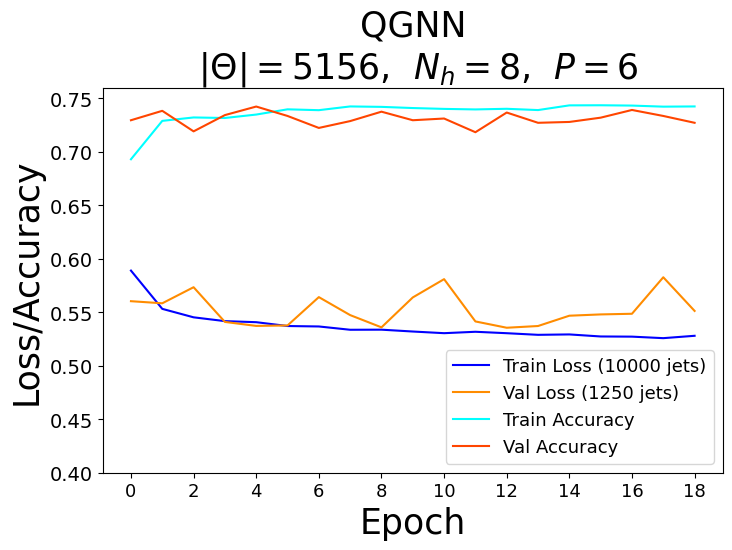

In [108]:
plt.figure(figsize=(8,5))
plt.plot(qgnn_model_and_history['history']['train_loss'],c='b',label=f'Train Loss ({train_index} jets)')
plt.plot(qgnn_model_and_history['history']['val_loss'],c='darkorange',label=f'Val Loss ({val_index-train_index} jets)')
plt.plot(train_acc,c='cyan',label='Train Accuracy')
plt.plot(val_acc,c='orangered',label='Val Accuracy')
plt.title(f'QGNN\n $|\Theta| = {count}$,  $N_h={embedding_size}$,  $P={n_layers}$', fontsize=25)
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss/Accuracy',fontsize=25)
plt.legend(fontsize = 13, loc = 'lower right')
plt.xticks(fontsize=13,ticks=[i for i in range(0,epochs,2)])
plt.yticks(fontsize=14)
plt.ylim([0.40,0.76])
plt.savefig(plot_path+f'qgnn_training_{count}_{embedding_size}_{n_layers}_{seed}.png',bbox_inches='tight')

In [109]:
model.eval()
with torch.no_grad():
    size = len(test_quantum_dataloader)
    num_correct = 0
    labels_all = None
    for i,data in enumerate(test_quantum_dataloader):
        if i==0:
            node_size, n_feat = data[0].x.size()
        batch_size = data.x.shape[0]//node_size
        inputs = data.pos.reshape(batch_size,2*int(2**node_size)*int(2**node_size)).to(device)
        labels = data.y.long().reshape(batch_size,).to(device)

        labels_pred = model(inputs,data.x.cfloat().to(device))
        num_correct += (labels_pred.argmax(dim=1)==labels).sum().int()

        if labels_all is not None:
            labels_all = torch.cat([labels_all,labels],dim=0)
            labels_pred_all = torch.cat([labels_pred_all,labels_pred],dim=0)
        else:
            labels_all = copy.deepcopy(labels)
            labels_pred_all = copy.deepcopy(labels_pred)

In [110]:
labels_all = copy.deepcopy(labels_all.cpu())
labels_pred_all = copy.deepcopy(labels_pred_all.cpu())

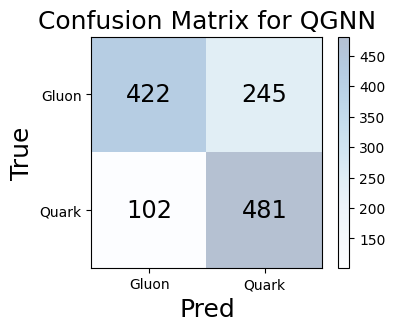

Accuracy for QGNN:  tensor(0.7224)


In [111]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=labels_all, y_pred=labels_pred_all.argmax(dim=1))
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(4, 3))
im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Pred', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.title('Confusion Matrix for QGNN', fontsize=18)
plt.xticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.yticks(ticks=[0,1],labels=['Gluon','Quark'])
plt.colorbar(im)
plt.show()

size=labels_all.shape[0]
num_correct = (labels_all==labels_pred_all.argmax(dim=1)).sum().int()
print('Accuracy for QGNN: ',num_correct/size)

In [112]:
from sklearn.metrics import roc_curve, roc_auc_score
first_idx = torch.arange(0,labels_pred_all.shape[0])
y_score_qgnn = labels_pred_all[(first_idx,labels_all.int())]
fpr_qgnn, tpr_qgnn, thresholds = roc_curve(labels_all, y_score_qgnn)
auc_score_qgnn = roc_auc_score(labels_all, y_score_qgnn)

In [113]:
import csv

# Save first 4 variables to CSV (train_loss, val_loss, train_acc, val_acc)
with open('qgnn_model_history.csv', 'w', newline='') as file1:
    writer = csv.writer(file1)
    # Writing the headers
    writer.writerow(['train_loss', 'val_loss', 'train_acc', 'val_acc'])
    # Writing the data
    for i in range(len(qgnn_model_and_history["history"]["train_loss"])):
        writer.writerow([
            qgnn_model_and_history["history"]["train_loss"][i],
            qgnn_model_and_history["history"]["val_loss"][i],
            qgnn_model_and_history["history"]["train_acc"][i].cpu().numpy(),
            qgnn_model_and_history["history"]["val_acc"][i].cpu().numpy()
        ])

# Save last 4 variables to another CSV (fpr_eqgnn, tpr_eqgnn, labels_all, y_score_eqgnn)
with open('qgnn_roc_data.csv', 'w', newline='') as file2:
    writer = csv.writer(file2)
    # Writing the headers
    writer.writerow(['fpr_eqgnn', 'tpr_eqgnn', 'labels_all', 'y_score_eqgnn'])
    # Writing the data
    for i in range(len(fpr_qgnn)):
        writer.writerow([
            fpr_qgnn[i],
            tpr_qgnn[i],
            labels_all[i].cpu().numpy(),
            y_score_qgnn[i].cpu().numpy()
        ])


In [114]:
np.save(plot_path+f'fpr_qgnn_{count}_{embedding_size}_{n_layers}_{seed}.npy',fpr_qgnn)
np.save(plot_path+f'tpr_qgnn_{count}_{embedding_size}_{n_layers}_{seed}.npy',tpr_qgnn)
np.save(plot_path+f'y_score_qgnn_{count}_{embedding_size}_{n_layers}_{seed}.npy',y_score_qgnn)
np.save(plot_path+f'labels_all_qgnn_{count}_{embedding_size}_{n_layers}_{seed}.npy',labels_all.numpy())

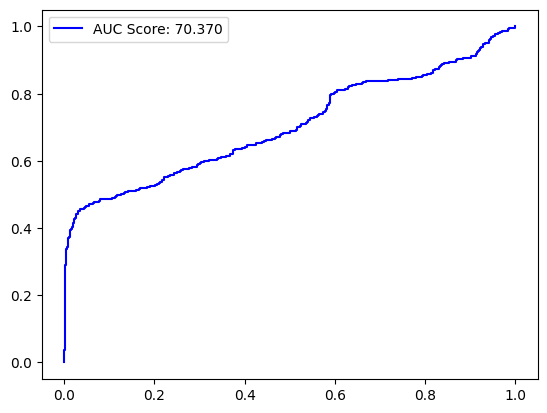

In [115]:
plt.plot(fpr_qgnn,tpr_qgnn,label = f'AUC Score: {100*auc_score_qgnn:.3f}',c='b')
plt.legend()

Test Loss: 0.5608
Test Accuracy: 72.2
Area Under Curve (AUC): 0.7037
F1 Score: 0.7209
IMTAFE: 0.7349


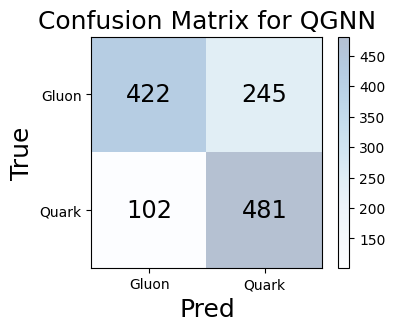

In [116]:
import torch
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import copy

model.eval()
with torch.no_grad():
    size = len(test_quantum_dataloader)
    num_correct = 0
    labels_all = None
    total_loss = 0.0
    criterion = torch.nn.CrossEntropyLoss()  # Assuming you're using CrossEntropyLoss

    for i, data in enumerate(test_quantum_dataloader):
        if i == 0:
            node_size, n_feat = data[0].x.size()
        batch_size = data.x.shape[0] // node_size
        inputs = data.pos.reshape(batch_size, 2 * int(2**node_size) * int(2**node_size)).to(device)
        labels = data.y.long().reshape(batch_size,).to(device)

        labels_pred = model(inputs, data.x.cfloat().to(device))
        loss = criterion(labels_pred, labels)
        total_loss += loss.item() * batch_size
        num_correct += (labels_pred.argmax(dim=1) == labels).sum().int()

        if labels_all is not None:
            labels_all = torch.cat([labels_all, labels], dim=0)
            labels_pred_all = torch.cat([labels_pred_all, labels_pred], dim=0)
        else:
            labels_all = copy.deepcopy(labels)
            labels_pred_all = copy.deepcopy(labels_pred)

    # Calculate metrics
    test_loss = total_loss / len(test_quantum_dataloader.dataset)
    test_accuracy = 100.0 * num_correct / len(test_quantum_dataloader.dataset)

    labels_all_cpu = labels_all.cpu()
    labels_pred_all_cpu = labels_pred_all.cpu()

    conf_matrix = confusion_matrix(y_true=labels_all_cpu, y_pred=labels_pred_all_cpu.argmax(dim=1))

    first_idx = torch.arange(0, labels_pred_all.shape[0])
    y_score_qgnn = labels_pred_all[(first_idx, labels_all.int())]
    fpr_qgnn, tpr_qgnn, thresholds = roc_curve(labels_all_cpu, y_score_qgnn.cpu())
    auc_score_qgnn = roc_auc_score(labels_all_cpu, y_score_qgnn.cpu())

    f1 = f1_score(labels_all_cpu, labels_pred_all_cpu.argmax(dim=1), average='weighted')

    # Calculate IMTAFE (assuming it's the Intersection over Mean)
    TP = conf_matrix[1, 1]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    IMTAFE = 2 * TP / (2 * TP + FP + FN)

    # Print results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.1f}")
    print(f"Area Under Curve (AUC): {auc_score_qgnn:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"IMTAFE: {IMTAFE:.4f}")

    # Confusion Matrix Visualization
    fig, ax = plt.subplots(figsize=(4, 3))
    im = ax.imshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Pred', fontsize=18)
    plt.ylabel('True', fontsize=18)
    plt.title('Confusion Matrix for QGNN', fontsize=18)
    plt.xticks(ticks=[0,1], labels=['Gluon','Quark'])
    plt.yticks(ticks=[0,1], labels=['Gluon','Quark'])
    plt.colorbar(im)
    plt.show()

# Note: Training metrics are not available in this evaluation code.
# They should be collected during the training phase.